Ipython notebook to examine redrock redshift failures for galaxies with high H$\alpha$ line flux

In [1]:
import os
import numpy as np 
from scipy.signal import medfilt
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM
# -- desihub -- 
import redrock as RedRock
from redrock.external import desi
from redrock import templates as rr_templates

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Load up the Redrock templates

In [3]:
templates_path = RedRock.templates.find_templates(None)
templates = {} 
for el in templates_path: 
    t = RedRock.templates.Template(filename=el)
    templates[t.full_type] = t

DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-3.9968 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Carbon.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Ldwarf.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


Read in GAMA-legacy catalog in `field` region for the meta data

In [4]:
field = 'g15'
# read in GAMA-Legacy survey
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

In [5]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies total' % ngal)

63004 galaxies total


In [6]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

Read in dark sky simulated spectra for galaxy `i_gal`

In [7]:
i_block = 5
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])

f_z_dark = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')
print('%i simulated spectra with redrock redshifts' % len(zdark_data['Z']))

1000 simulated spectra with redrock redshifts


Read in simulated spectra

In [8]:
f_spec_dark = ''.join([dir_spectra, 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

Read in accompanying redrock output data

In [9]:
f_rr_dark = ''.join([dir_redrock, 
                     'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.h5'])
zscan_dark, zfit_dark = RedRock.results.read_zscan(f_rr_dark)

Get the source spectra for these galaxies as well, in case we want to look at them. These are *not* properly flux calibrated to reproduce the $r$-band aperture flux mangitudes

In [10]:
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg, index=i_dark)
s_bgs = FM.BGSsourceSpectra(wavemin=1500.0, wavemax=2e4)
vdisp = np.repeat(100.0, len(i_dark))
emline_flux = s_bgs.EmissionLineFlux(gleg, index=i_dark, dr_gama=3, silent=True)
flux_eml, wave, _ = s_bgs.Spectra(r_mag_legacy_apflux[i_dark], redshift[i_dark], vdisp, seed=1, 
                                  templateid=match, emflux=emline_flux, mag_em=r_mag_gama[i_dark], silent=True)

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


In [11]:
print flux_eml.shape, wave.shape

(1000, 92500) (92500,)


In [12]:
def GAMA_subsample(index, colour='C0', size=None): 
    ''' highlight the subsample in the color-magnitude and color-Halpha 
    relations of the entire GAMA sample
    '''
    if size is None: ss = 1.
    else: ss=size
    fig = plt.figure(figsize=(15, 4))
    ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, y, ylbl in zip(range(1,4), ys, ylbls):
        sub = fig.add_subplot(1,3,i)
        sub.scatter(r_absmag_gama, y, c='k', s=1.)
        sub.scatter(r_absmag_gama[index], y[index], c=colour, s=ss)
        if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
        sub.set_xlim([-14., -24])
        sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
        sub.set_ylim([-0.2, 1.6])
    fig.subplots_adjust(wspace=0.3)

    fig = plt.figure(figsize=(15, 4))
    xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
        sub = fig.add_subplot(1, len(xs), i)
        hasha = (gama_ha > 0)
        sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
        sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
        hasha = (gama_ha[index] > 0)
        sub.scatter(x[index][hasha], gama_ha[index][hasha], c=colour, s=ss)
        sub.scatter(x[index][~hasha], np.repeat(1e-2, np.sum(~hasha)), c=colour, s=ss)
        sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
        sub.set_xlim([-0.2, 2.])
        if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
        sub.set_ylim([5e-3, 2e4])
        sub.set_yscale('log')
    fig.subplots_adjust(wspace=0.3)
    return None 

In [13]:
# emission line keys int he Gleg catalog
emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
# corresponding labels
emline_labels = [r'[OII]$_b$', r'[OII]$_r$', r'$\mathrm{H}_\beta$',
                 r'[OIII]$_b$', r'[OIII]$_r$', r'[OI]$_b$', r'[OI]$_r$',
                 r'[NII]$_b$', r'$\mathrm{H}_\alpha$', r'[NII]$_r$',
                 r'[SII]$_b$', r'[SII]$_r$']
# corresponding wavelenghts
emline_lambda = [3726., 3729., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]
emline_xval = [3550., 3750., 4700., 4900., 5200., 6000., 6200., 6350., 6550., 6700., 6850., 7000.]

In [14]:
def plotspec(target, zscan, zfit, xrange0=None, yrange0=None, xrange1=None, yrange1=None, 
             otherznum=None, otherznum_kwargs=None): 
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    if otherznum is not None: 
        zz_other = zfit_i[zfit_i['znum'] == otherznum][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(16,10)) 
    _ax1 = fig.add_subplot(211)
    for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
        if spectype in zscan[target.id]:
            zx = zscan[target.id][spectype]
            _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                      label='_none_')
            _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                      label=spectype)
    _ax1.plot(zfit_i['z'], zfit_i['chi2'], 'r.', label='_none_')
    if xrange0 is not None: _ax1.set_xlim(xrange0)
    if yrange0 is not None: _ax1.set_ylim(yrange0)
    for row in zfit_i: 
        if xrange0 is not None or yrange0 is not None:
            if xrange0 is not None: xif = (row['z'] > xrange0[0]) & (row['z'] < xrange0[1])
            else: xif = True
            if yrange0 is not None: yif = (row['chi2'] > yrange0[0]) & (row['chi2'] < yrange0[1])
            else: yif = True
            if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
        else:
            _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
    _ax1.axvline(zz['z'], color='k', alpha=0.1)
    _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
    _ax1.legend()
    _ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']))
    _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    _ax1.set_xlabel('redshift', fontsize=25)
    
    _ax2 = fig.add_subplot(212)        
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        ## model[isbad] = mx[isbad]
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(flux, 1), alpha=0.5)
        _ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), 'k-', alpha=0.8)
        if otherznum is not None: 
            mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
            model = spec.R.dot(mx)
            isbad = (spec.ivar == 0)
            model[isbad] = np.NaN
            if otherznum_kwargs is None: 
                _ax2.plot(spec.wave, medfilt(model, 1), 'C0-', alpha=0.8)
            else: 
                _ax2.plot(spec.wave, medfilt(model, 1), **otherznum_kwargs)
        ymin = min(ymin, np.percentile(flux[~isbad], 1))
        ymax = max(ymax, np.percentile(flux[~isbad], 99), np.max(model)*1.05)

    #- Label object type and redshift
    label = 'znum {} {} z={:.3f}'.format(0, tp.full_type, zz['z'])
    #print('target {} id {} {}'.format(self.itarget, target.id, label))
    ytext = ymin+0.9*(ymax-ymin)
    if xrange1 is not None: _ax2.text(xrange1[0], ytext, label)
    else: _ax2.text(3800, ytext, label)
    _ax2.set_ylim(ymin, ymax)
    _ax2.set_xlim(3500,10100)   
    _ax2.set_ylabel('flux', fontsize=25)
    _ax2.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
    plt.show()
    return None

def chi2_lambda(target, zscan, zfit, xrange=None, yrange=None, sub=None, **plt_kwargs):
    ''' plot chi-squared as a function of wavelength 
    '''
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    if sub is None: 
        fig = plt.figure(figsize=(12,4)) 
        sub = fig.add_subplot(111)
    
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        ivar = spec.ivar.copy() 
        isbad = (spec.ivar == 0)
        chi2 = (flux - model)**2 * ivar
        ## model[isbad] = mx[isbad]
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, **plt_kwargs) #medfilt(flux, 1), alpha=0.5)
        
        #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        #model[isbad] = np.NaN
        #_ax2.plot(spec.wave, medfilt(model, 1), 'k-', alpha=0.8)

        ymin = min(ymin, np.percentile(chi2[~isbad], 1))
        ymax = max(ymax, np.percentile(chi2[~isbad], 99), np.max(chi2)*1.05)

    #- Label object type and redshift
    label = 'znum {} {} z={:.3f}'.format(0, tp.full_type, zz['z'])
    if yrange is not None: ymin, ymax = yrange
    ytext = ymin+0.9*(ymax-ymin)
    if xrange is not None: sub.text(xrange[0], ytext, label)
    else: sub.text(3800, ytext, label)
    if yrange is not None: sub.set_ylim(yrange)
    else: sub.set_ylim(ymin, ymax)
    #sub.set_yscale('log')
    sub.set_xlim(3500,10100)   
    sub.set_ylabel('$\chi^2(\lambda)$', fontsize=25)
    sub.set_xlabel('wavelength [A]', fontsize=25)    
    if sub is None: 
        fig.subplots_adjust(hspace=0.3)
        plt.show()
    return sub

def chi2z(target, zscan, zfit, xranges=None, yranges=None):
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(4*len(xranges),4)) 
    for i in range(len(xranges)): 
        _ax1 = fig.add_subplot(1,len(xranges),i+1)
        for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
            if spectype in zscan[target.id]:
                zx = zscan[target.id][spectype]
                _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                          label='_none_')
                _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                          label=spectype)
        #_ax1.plot(zfit['z'], zfit['chi2'], 'r.', label='_none_')
        if xranges is not None: _ax1.set_xlim(xranges[i])
        if yranges is not None: _ax1.set_ylim(yranges[i])
        for row in zfit_i: 
            if xranges is not None or yranges is not None:
                if xranges is not None: xif = (row['z'] > xranges[i][0]) & (row['z'] < xranges[i][1])
                else: xif = True
                if yranges is not None: yif = (row['chi2'] > yranges[i][0]) & (row['chi2'] < yranges[i][1])
                else: yif = True
                if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
            else:
                _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
        _ax1.axvline(zz['z'], color='k', alpha=0.1)
        _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
        #_ax1.legend()
        _ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']))
        _ax1.set_xlabel('redshift', fontsize=25)
        if i == 0: _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    fig.subplots_adjust(wspace=0.3)
    plt.show()
    return None

In [37]:
#Here are the 1000 galaxies in the spectra block
#GAMA_subsample(i_dark, colour='C0')

For now lets focus solely on synthetic spectra with dark sky brightness, which has higher signal to noise, so in principle it should be easier for redrock. Also lets narrow it down further to synthetic spectra w/ high H$\alpha$ line flux. For these galaxies, redrock definitely should *not* fail.

In [19]:
zfail_dark_ha = (((np.abs(redshift[i_dark] - zdark_data['Z'])/(1.+redshift[i_dark]) > 0.003)) & 
                 (gama_ha[i_dark] > 1e3))
print('for %i galaxies with dark sky and Halpha > 10^3 redrock fails' % np.sum(zfail_dark_ha))

for 11 galaxies with dark sky and Halpha > 10^3 redrock fails


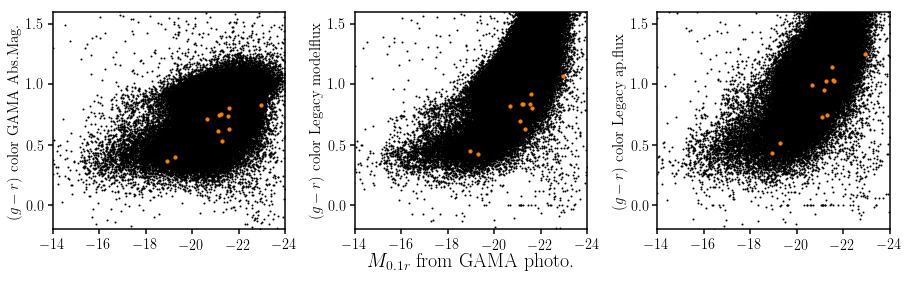

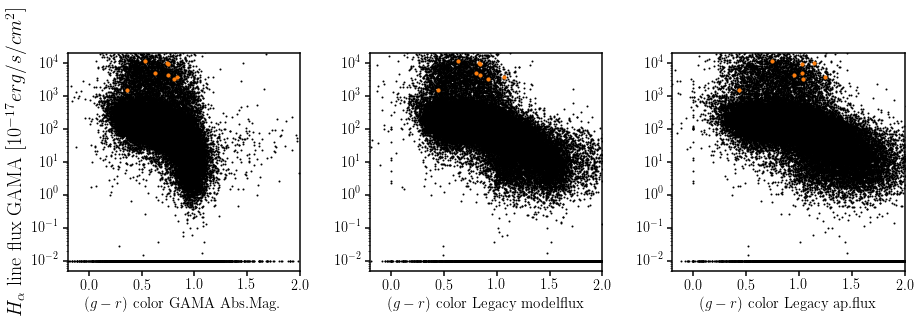

In [20]:
GAMA_subsample(i_dark[zfail_dark_ha], colour='C1', size=10)

Lets examine a handful of galaxies and see what their spectra look like

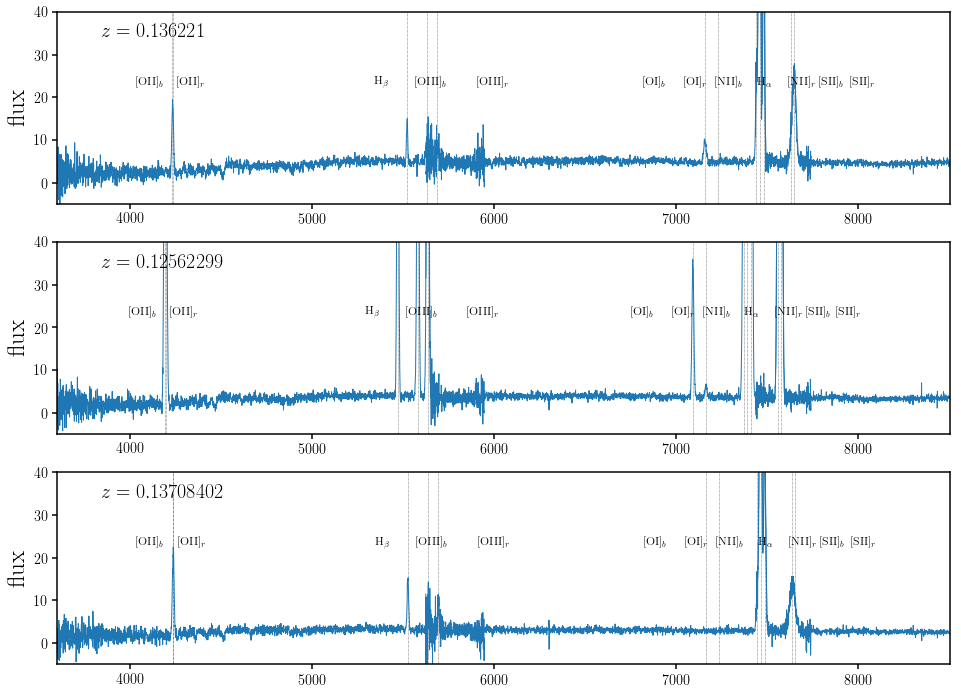

In [25]:
fig = plt.figure(figsize=(16,12))
for i_sub, ii in enumerate([0, 1, 3]): 
    sub = fig.add_subplot(3,1,i_sub+1)
    i_targ = np.arange(len(i_dark))[zfail_dark_ha][ii]
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        sub.plot(s_dark.wave, s_dark.flux, c='C0', lw=1.) #s=0.5)
    #sub.plot(wave, flux_eml[i_targ,:], c='k', lw=0.25)

    sub.text(0.05, 0.95, '$z='+str(redshift[i_dark][i_targ])+'$',
             ha='left', va='top', transform=sub.transAxes, fontsize=20)  
    emline_zlambda = (1.+redshift[i_dark][i_targ]) * np.array(emline_lambda)
    for i_l, zlambda in enumerate(emline_zlambda):
        # mark the redshifted wavelength of the emission line
        sub.vlines(zlambda, -100., 100., color='k', linestyle=':', linewidth=0.5)
        sub.text((1.+redshift[i_dark][i_targ])*emline_xval[i_l], 25., emline_labels[i_l],
                 ha='left', va='top', fontsize=12)
        
    if ii == 2: sub.set_xlabel('Wavelength', fontsize=25)
    sub.set_xlim([3600., 8500.])
    sub.set_ylabel('flux', fontsize=25)
    sub.set_ylim([-5., 40])

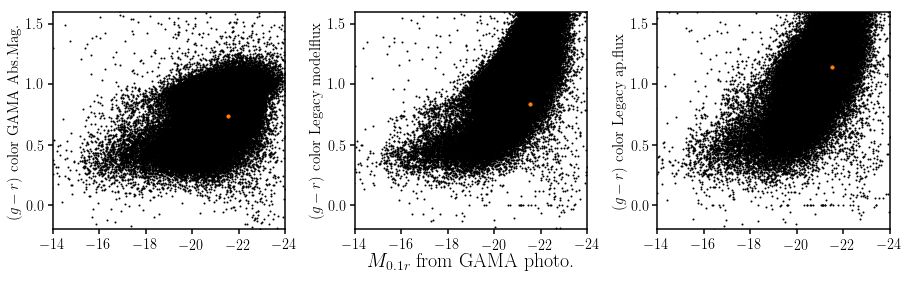

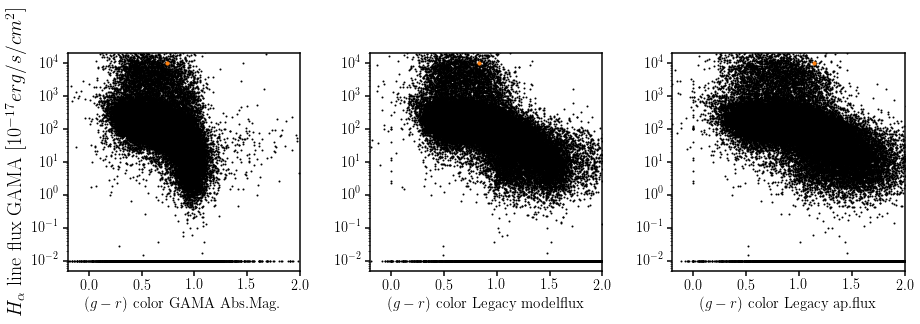

In [26]:
GAMA_subsample(i_dark[zfail_dark_ha][0], colour='C1', size=10)

i = 51 with z = 0.136221


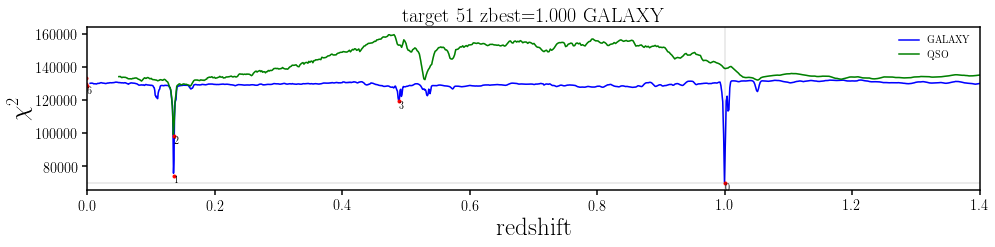

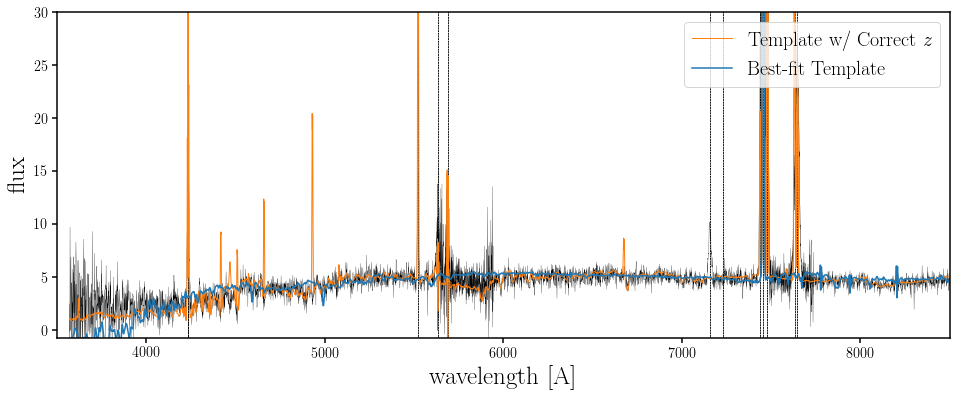

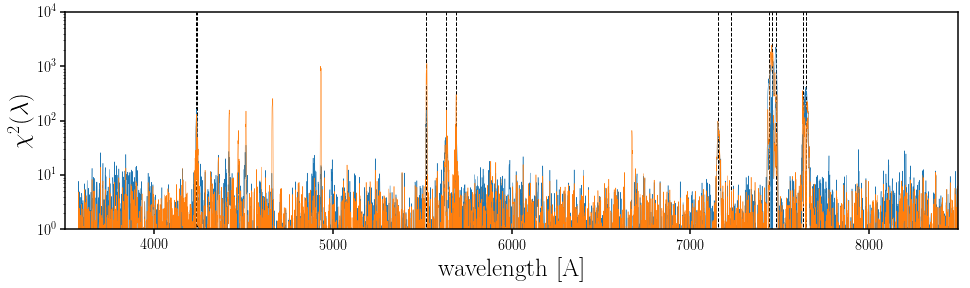

In [28]:
igal = np.arange(len(i_dark))[zfail_dark_ha][0]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
xrange0, yrange0 = [0., 1.4], None
xrange1, yrange1 = None, None 
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']

fulltype = zz['spectype']
tp = templates[fulltype]

fig = plt.figure(figsize=(16,3)) 
_ax1 = fig.add_subplot(111)
for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
    if spectype in zscan[target.id]:
        zx = zscan[target.id][spectype]
        _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                  label='_none_')
        _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                  label=spectype)
_ax1.plot(zfit_i['z'], zfit_i['chi2'], 'r.', label='_none_')
if xrange0 is not None: _ax1.set_xlim(xrange0)
if yrange0 is not None: _ax1.set_ylim(yrange0)
for row in zfit_i: 
    if xrange0 is not None or yrange0 is not None:
        if xrange0 is not None: xif = (row['z'] > xrange0[0]) & (row['z'] < xrange0[1])
        else: xif = True
        if yrange0 is not None: yif = (row['chi2'] > yrange0[0]) & (row['chi2'] < yrange0[1])
        else: yif = True
        if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
    else:
        _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
_ax1.axvline(zz['z'], color='k', alpha=0.1)
_ax1.axhline(zz['chi2'], color='k', alpha=0.1)
_ax1.legend()
_ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']), fontsize=20)
_ax1.set_ylabel(r'$\chi^2$', fontsize=25)
_ax1.set_xlabel('redshift', fontsize=25)

fig = plt.figure(figsize=(16,6)) 
_ax2 = fig.add_subplot(111)
specs_to_read = target.spectra
ymin = ymax = 0.0
for i_s, spec in enumerate(specs_to_read):
    emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
    for i_l, zlambda in enumerate(emline_zlambda):
        # mark the redshifted wavelength of the emission line
        _ax2.vlines(zlambda, -100., 100., color='k', linestyle='--', linewidth=0.5)

    flux = spec.flux.copy()
    isbad = (spec.ivar == 0)
    flux[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(flux, 1), c='k', lw=0.25)#alpha=0.5)
    
    # correct answer
    mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
    model = spec.R.dot(mx)
    isbad = (spec.ivar == 0)
    model[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(model, 1), c='C1', lw=1, alpha=1, label='Template w/ Correct $z$')
    
    mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
    model = spec.R.dot(mx)
    #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
    model[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(model, 1), 'C0-', lw=1.5, alpha=1, label='Best-fit Template')
    if i_s == 0: _ax2.legend(loc='upper right', frameon=True, prop={'size':20})
    ymin = min(ymin, np.percentile(flux[~isbad], 1))
    ymax = max(ymax, np.percentile(flux[~isbad], 99), np.max(model)*1.05)
ymax=30.
_ax2.set_ylim(ymin, ymax)
_ax2.set_xlim(3500,8500)   
_ax2.set_ylabel('flux', fontsize=25)
_ax2.set_xlabel('wavelength [A]', fontsize=25)  

fig = plt.figure(figsize=(16,4)) 
sub = fig.add_subplot(111)
emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
for i_l, zlambda in enumerate(emline_zlambda):
    # mark the redshifted wavelength of the emission line
    sub.vlines(zlambda, -100., 1e4, color='k', linestyle='--', linewidth=1)
    
specs_to_read = target.spectra
ymin = ymax = 0.0
for spec in specs_to_read:
    mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
    model = spec.R.dot(mx)
    flux = spec.flux.copy()
    ivar = spec.ivar.copy() 
    isbad = (spec.ivar == 0)
    chi2 = (flux - model)**2 * ivar
    chi2[isbad] = np.NaN
    sub.plot(spec.wave, chi2, c='C0', lw=0.5) 
    
    mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
    model = spec.R.dot(mx)
    isbad = (spec.ivar == 0)
    model[isbad] = np.NaN
    chi2 = (flux - model)**2 * ivar
    chi2[isbad] = np.NaN
    sub.plot(spec.wave, chi2, c='C1', lw=0.5)#, alpha=0.5) 
    
    ymin = min(ymin, np.percentile(chi2[~isbad], 1))
    ymax = max(ymax, np.percentile(chi2[~isbad], 99), np.max(chi2)*1.05)
#sub.set_ylim(ymin, ymax)
sub.set_ylim(1e0,1e4)
sub.set_yscale('log')
sub.set_xlim(3500,8500)   
sub.set_ylabel('$\chi^2(\lambda)$', fontsize=25)
sub.set_xlabel('wavelength [A]', fontsize=25)    
fig.subplots_adjust(hspace=0.3)
plt.show()

lets focus on some of the emission line regions

i = 51 with z = 0.136221


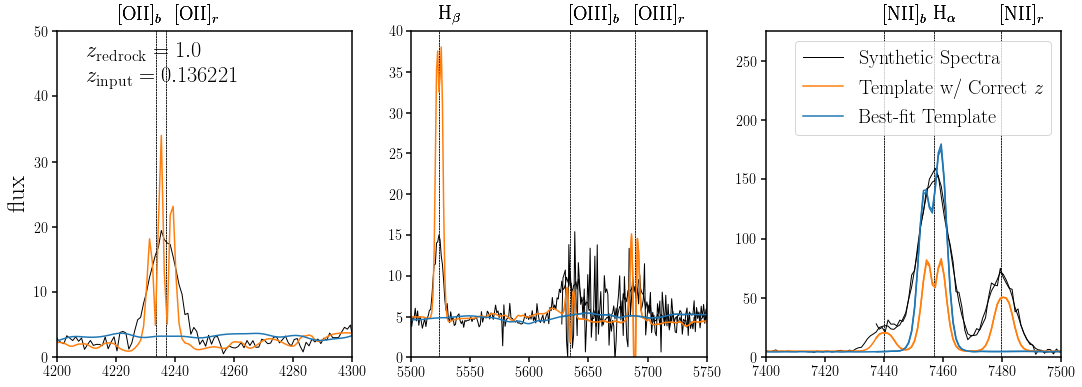

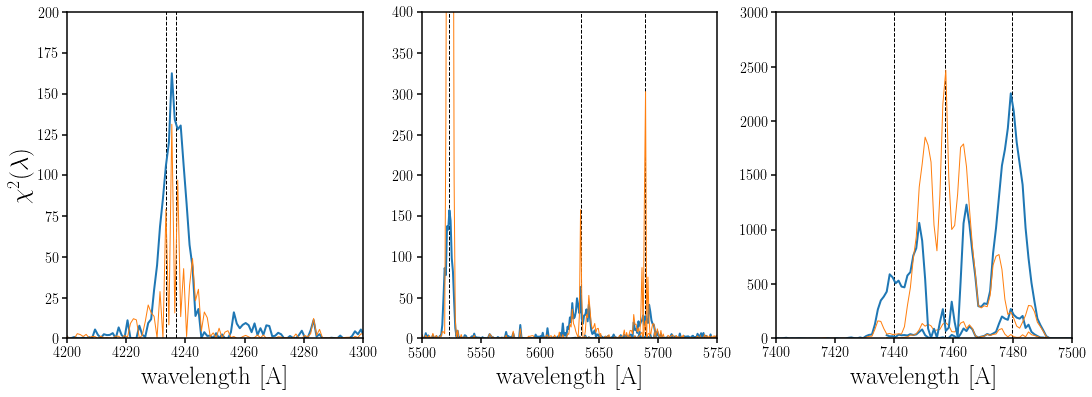

In [29]:
igal = np.arange(len(i_dark))[zfail_dark_ha][0]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']
#emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
#emline_lambda = [3726., 3729., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]
emline_xval = [3715., 3732., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]

xlims = [[4200., 4300.], [5500., 5750.], [7400., 7500.]]
ylims0 = [[0., 50.], [0., 40.], [0., 275.]]
ylims1 = [[0., 200.], [0., 400.], [0., 3e3]]

fig = plt.figure(figsize=(len(xlims)*6,6)) 
for i_x, xlim in enumerate(xlims): 
    _ax2 = fig.add_subplot(1,len(xlims),i_x+1)
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for i_s, spec in enumerate(specs_to_read):
        emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
        for i_l, zlambda in enumerate(emline_zlambda):
            if zlambda < xlim[0] or zlambda > xlim[1]: continue
            # mark the redshifted wavelength of the emission line
            _ax2.vlines(zlambda, -100., 1e3, color='k', linestyle='--', linewidth=0.5)
            _ax2.text((1.+redshift[i_dark][igal])*emline_xval[i_l], 1.075*ylims0[i_x][1], 
                      emline_labels[i_l],ha='left', va='top', fontsize=20)    
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, flux, c='k', lw=1, label='Synthetic Spectra')#alpha=0.5)
        #_ax2.plot(spec.wave, medfilt(flux, 1), c='C1', lw=2)#alpha=0.5)

        # correct answer
        mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
        model = spec.R.dot(mx)
        isbad = (spec.ivar == 0)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), c='C1', lw=1.5, label='Template w/ Correct $z$')

        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), 'C0-', lw=1.5, label='Best-fit Template')
        if (i_s == 0) and (i_x == len(xlims)-1): _ax2.legend(loc='upper right', frameon=True, prop={'size': 20})
    #- Label object type and redshift
    if i_x == 0: 
        _ax2.text(xlim[0]+0.1*(xlim[1]-xlim[0]), ylims0[i_x][0]+0.83*(ylims0[i_x][1]-ylims0[i_x][0]), 
                  r"$z_\mathrm{redrock}="+str(round(zz['z'],3))+'$\n $z_\mathrm{input}='+str(redshift[i_dark][igal])+'$', 
                 fontsize=22.5)
    _ax2.set_ylim(ylims0[i_x])
    _ax2.set_xlim(xlim)   
    if i_x == 0: _ax2.set_ylabel('flux', fontsize=25)

fig = plt.figure(figsize=(len(xlims)*6,6)) 
for i_x, xlim in enumerate(xlims): 
    sub = fig.add_subplot(1,len(xlims),i_x+1)

    emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
    for i_l, zlambda in enumerate(emline_zlambda):
        if zlambda < xlim[0] or zlambda > xlim[1]: continue
        # mark the redshifted wavelength of the emission line
        sub.vlines(zlambda, -100., 1e4, color='k', linestyle='--', linewidth=1)
        #sub.text((1.+redshift[i_dark][igal])*emline_xval[i_l], 200., emline_labels[i_l], ha='left', va='top', fontsize=12)

    specs_to_read = target.spectra
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        ivar = spec.ivar.copy() 
        isbad = (spec.ivar == 0)
        chi2 = (flux - model)**2 * ivar
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, c='C0', lw=2) 

        mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
        model = spec.R.dot(mx)
        isbad = (spec.ivar == 0)
        model[isbad] = np.NaN
        chi2 = (flux - model)**2 * ivar
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, c='C1', lw=1.) 
    sub.set_ylim(ylims1[i_x])
    #sub.set_yscale('log')
    sub.set_xlim(xlim)   
    if i_x == 0: sub.set_ylabel('$\chi^2(\lambda)$', fontsize=25)
    sub.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
plt.show()

i = 221 with z = 0.125623


Text(0.5,0,'wavelength [A]')

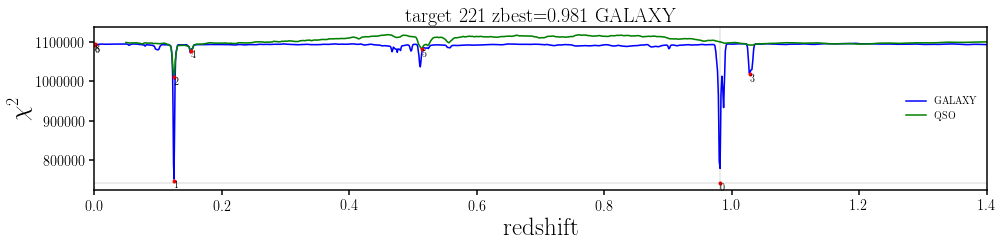

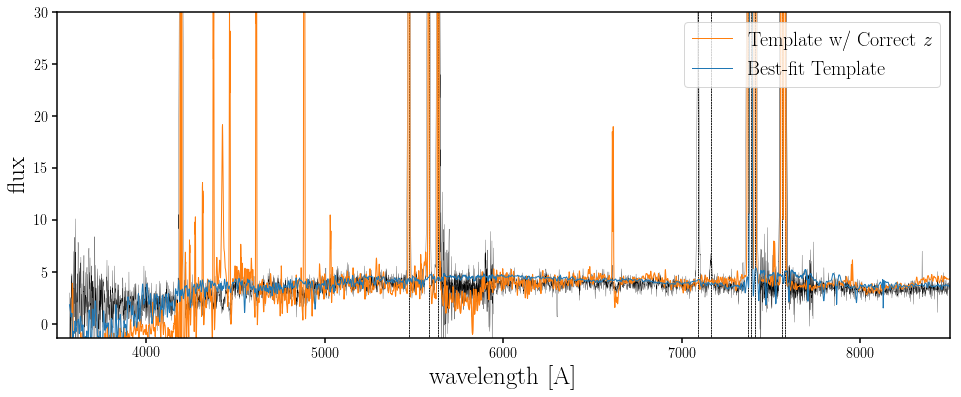

In [30]:
igal = np.arange(len(i_dark))[zfail_dark_ha][1]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
xrange0, yrange0 = [0., 1.4], None
xrange1, yrange1 = None, None 
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']

fulltype = zz['spectype']
tp = templates[fulltype]

fig = plt.figure(figsize=(16,3)) 
_ax1 = fig.add_subplot(111)
for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
    if spectype in zscan[target.id]:
        zx = zscan[target.id][spectype]
        _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                  label='_none_')
        _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                  label=spectype)
_ax1.plot(zfit_i['z'], zfit_i['chi2'], 'r.', label='_none_')
if xrange0 is not None: _ax1.set_xlim(xrange0)
if yrange0 is not None: _ax1.set_ylim(yrange0)
for row in zfit_i: 
    if xrange0 is not None or yrange0 is not None:
        if xrange0 is not None: xif = (row['z'] > xrange0[0]) & (row['z'] < xrange0[1])
        else: xif = True
        if yrange0 is not None: yif = (row['chi2'] > yrange0[0]) & (row['chi2'] < yrange0[1])
        else: yif = True
        if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
    else:
        _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
_ax1.axvline(zz['z'], color='k', alpha=0.1)
_ax1.axhline(zz['chi2'], color='k', alpha=0.1)
_ax1.legend()
_ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']), fontsize=20)
_ax1.set_ylabel(r'$\chi^2$', fontsize=25)
_ax1.set_xlabel('redshift', fontsize=25)

fig = plt.figure(figsize=(16,6)) 
_ax2 = fig.add_subplot(111)
specs_to_read = target.spectra
ymin = ymax = 0.0
for i_s, spec in enumerate(specs_to_read):
    emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
    for i_l, zlambda in enumerate(emline_zlambda):
        # mark the redshifted wavelength of the emission line
        _ax2.vlines(zlambda, -100., 100., color='k', linestyle='--', linewidth=0.5)

    flux = spec.flux.copy()
    isbad = (spec.ivar == 0)
    flux[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(flux, 1), c='k', lw=0.25)#alpha=0.5)
    
    # correct answer
    mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
    model = spec.R.dot(mx)
    isbad = (spec.ivar == 0)
    model[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(model, 1), c='C1', lw=1, alpha=1, label='Template w/ Correct $z$')
    
    mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
    model = spec.R.dot(mx)
    #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
    model[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(model, 1), 'C0-', lw=1, alpha=1, label='Best-fit Template')
    if i_s == 0: _ax2.legend(loc='upper right', frameon=True, prop={'size':20})
    ymin = min(ymin, np.percentile(flux[~isbad], 1))
    ymax = max(ymax, np.percentile(flux[~isbad], 99), np.max(model)*1.05)
ymax=30.
_ax2.set_ylim(ymin, ymax)
_ax2.set_xlim(3500,8500)   
_ax2.set_ylabel('flux', fontsize=25)
_ax2.set_xlabel('wavelength [A]', fontsize=25)  

i = 221 with z = 0.125623


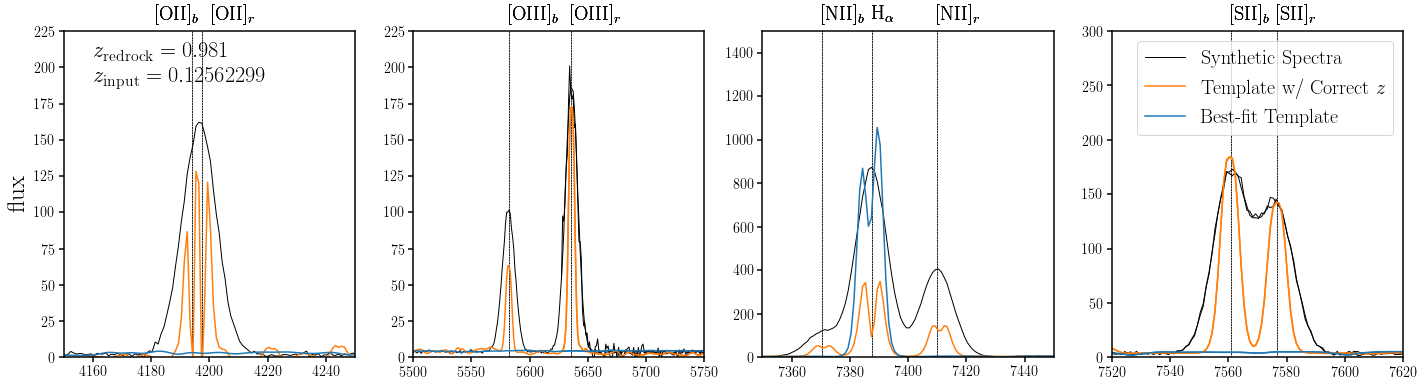

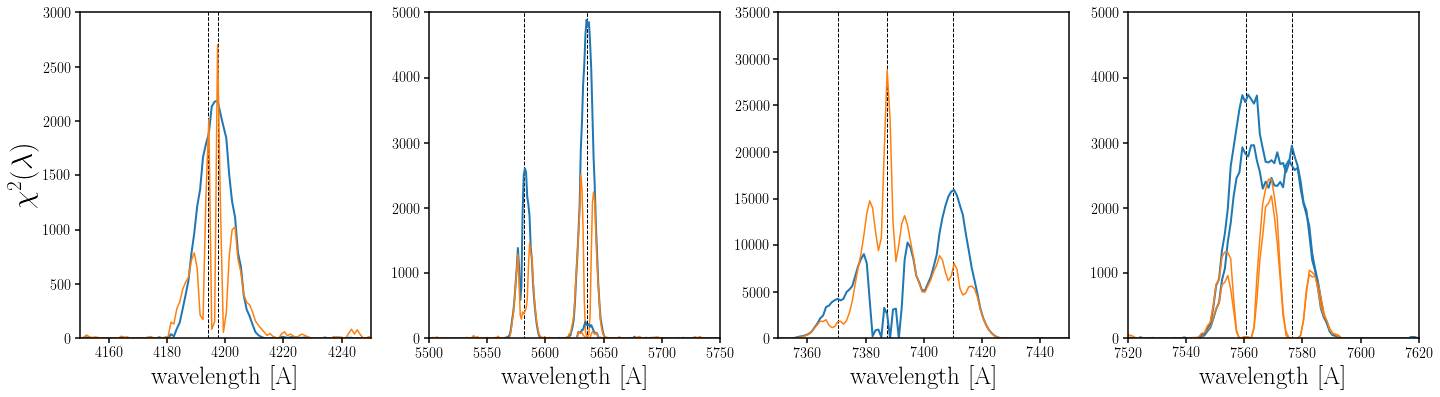

In [31]:
igal = np.arange(len(i_dark))[zfail_dark_ha][1]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']
#emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
#emline_lambda = [3726., 3729., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]
emline_xval = [3715., 3732., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]

xlims = [[4150., 4250.], [5500., 5750.], [7350., 7450.], [7520, 7620]]
ylims0 = [[0., 2.25e2], [0., 2.25e2], [0., 1.5e3], [0., 3e2]]
ylims1 = [[0., 3e3], [0., 5e3], [0., 3.5e4], [0., 5e3]]

fig = plt.figure(figsize=(len(xlims)*6,6)) 
for i_x, xlim in enumerate(xlims): 
    _ax2 = fig.add_subplot(1,len(xlims),i_x+1)
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for i_s, spec in enumerate(specs_to_read):
        emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
        for i_l, zlambda in enumerate(emline_zlambda):
            if zlambda < xlim[0] or zlambda > xlim[1]: continue
            # mark the redshifted wavelength of the emission line
            _ax2.vlines(zlambda, -100., 1e5, color='k', linestyle='--', linewidth=0.5)
            _ax2.text((1.+redshift[i_dark][igal])*emline_xval[i_l], 1.075*ylims0[i_x][1], 
                      emline_labels[i_l],ha='left', va='top', fontsize=20)    
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, flux, c='k', lw=1, label='Synthetic Spectra')#alpha=0.5)
        #_ax2.plot(spec.wave, medfilt(flux, 1), c='C1', lw=2)#alpha=0.5)

        # correct answer
        mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
        model = spec.R.dot(mx)
        isbad = (spec.ivar == 0)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), c='C1', lw=1.5, label='Template w/ Correct $z$')

        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), 'C0-', lw=1.5, label='Best-fit Template')
        if (i_s == 0) and (i_x == len(xlims)-1): _ax2.legend(loc='upper right', frameon=True, prop={'size': 20})
    #- Label object type and redshift
    if i_x == 0: 
        _ax2.text(xlim[0]+0.1*(xlim[1]-xlim[0]), ylims0[i_x][0]+0.83*(ylims0[i_x][1]-ylims0[i_x][0]), 
                  r"$z_\mathrm{redrock}="+str(round(zz['z'],3))+'$\n $z_\mathrm{input}='+str(redshift[i_dark][igal])+'$', 
                 fontsize=22.5)
    _ax2.set_ylim(ylims0[i_x])
    _ax2.set_xlim(xlim)   
    if i_x == 0: _ax2.set_ylabel('flux', fontsize=25)

fig = plt.figure(figsize=(len(xlims)*6,6)) 
for i_x, xlim in enumerate(xlims): 
    sub = fig.add_subplot(1,len(xlims),i_x+1)

    emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
    for i_l, zlambda in enumerate(emline_zlambda):
        if zlambda < xlim[0] or zlambda > xlim[1]: continue
        # mark the redshifted wavelength of the emission line
        sub.vlines(zlambda, -100., 1e5, color='k', linestyle='--', linewidth=1)
        #sub.text((1.+redshift[i_dark][igal])*emline_xval[i_l], 200., emline_labels[i_l], ha='left', va='top', fontsize=12)

    specs_to_read = target.spectra
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        ivar = spec.ivar.copy() 
        isbad = (spec.ivar == 0)
        chi2 = (flux - model)**2 * ivar
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, c='C0', lw=2) 

        mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
        model = spec.R.dot(mx)
        isbad = (spec.ivar == 0)
        model[isbad] = np.NaN
        chi2 = (flux - model)**2 * ivar
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, c='C1', lw=1.5) 
    sub.set_ylim(ylims1[i_x])
    #sub.set_yscale('log')
    sub.set_xlim(xlim)   
    if i_x == 0: sub.set_ylabel('$\chi^2(\lambda)$', fontsize=30)
    sub.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
plt.show()

i = 294 with z = 0.137084


Text(0.5,0,'wavelength [A]')

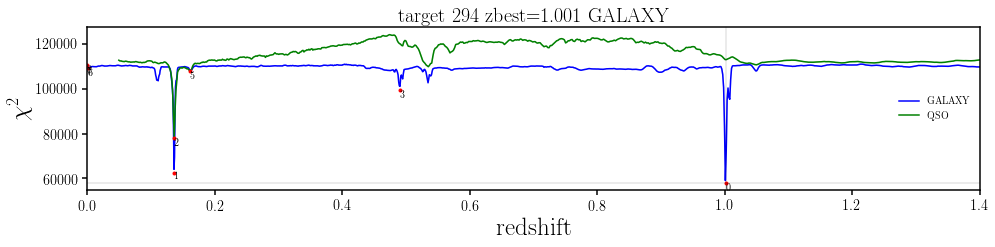

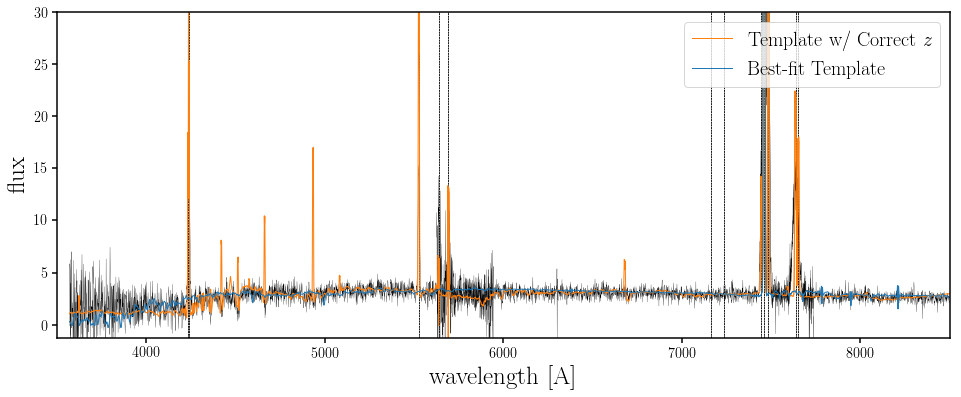

In [32]:
igal = np.arange(len(i_dark))[zfail_dark_ha][3]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
xrange0, yrange0 = [0., 1.4], None
xrange1, yrange1 = None, None 
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']

fulltype = zz['spectype']
tp = templates[fulltype]

fig = plt.figure(figsize=(16,3)) 
_ax1 = fig.add_subplot(111)
for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
    if spectype in zscan[target.id]:
        zx = zscan[target.id][spectype]
        _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                  label='_none_')
        _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                  label=spectype)
_ax1.plot(zfit_i['z'], zfit_i['chi2'], 'r.', label='_none_')
if xrange0 is not None: _ax1.set_xlim(xrange0)
if yrange0 is not None: _ax1.set_ylim(yrange0)
for row in zfit_i: 
    if xrange0 is not None or yrange0 is not None:
        if xrange0 is not None: xif = (row['z'] > xrange0[0]) & (row['z'] < xrange0[1])
        else: xif = True
        if yrange0 is not None: yif = (row['chi2'] > yrange0[0]) & (row['chi2'] < yrange0[1])
        else: yif = True
        if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
    else:
        _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
_ax1.axvline(zz['z'], color='k', alpha=0.1)
_ax1.axhline(zz['chi2'], color='k', alpha=0.1)
_ax1.legend()
_ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']), fontsize=20)
_ax1.set_ylabel(r'$\chi^2$', fontsize=25)
_ax1.set_xlabel('redshift', fontsize=25)

fig = plt.figure(figsize=(16,6)) 
_ax2 = fig.add_subplot(111)
specs_to_read = target.spectra
ymin = ymax = 0.0
for i_s, spec in enumerate(specs_to_read):
    emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
    for i_l, zlambda in enumerate(emline_zlambda):
        # mark the redshifted wavelength of the emission line
        _ax2.vlines(zlambda, -100., 100., color='k', linestyle='--', linewidth=0.5)

    flux = spec.flux.copy()
    isbad = (spec.ivar == 0)
    flux[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(flux, 1), c='k', lw=0.25)#alpha=0.5)
    
    # correct answer
    mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
    model = spec.R.dot(mx)
    isbad = (spec.ivar == 0)
    model[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(model, 1), c='C1', lw=1, alpha=1, label='Template w/ Correct $z$')
    
    mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
    model = spec.R.dot(mx)
    #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
    model[isbad] = np.NaN
    _ax2.plot(spec.wave, medfilt(model, 1), 'C0-', lw=1, alpha=1, label='Best-fit Template')
    if i_s == 0: _ax2.legend(loc='upper right', frameon=True, prop={'size':20})
    ymin = min(ymin, np.percentile(flux[~isbad], 1))
    ymax = max(ymax, np.percentile(flux[~isbad], 99), np.max(model)*1.05)
ymax=30.
_ax2.set_ylim(ymin, ymax)
_ax2.set_xlim(3500,8500)   
_ax2.set_ylabel('flux', fontsize=25)
_ax2.set_xlabel('wavelength [A]', fontsize=25)  

i = 294 with z = 0.137084


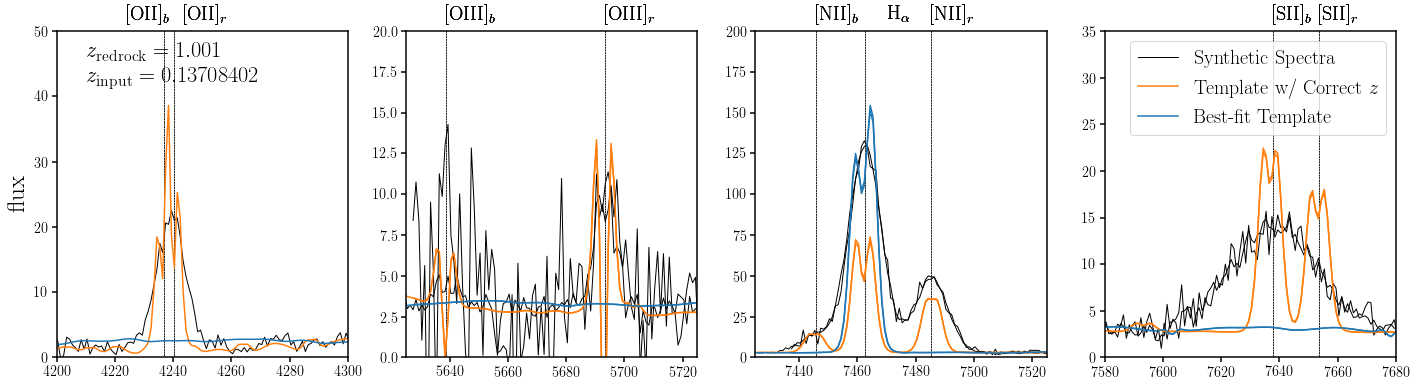

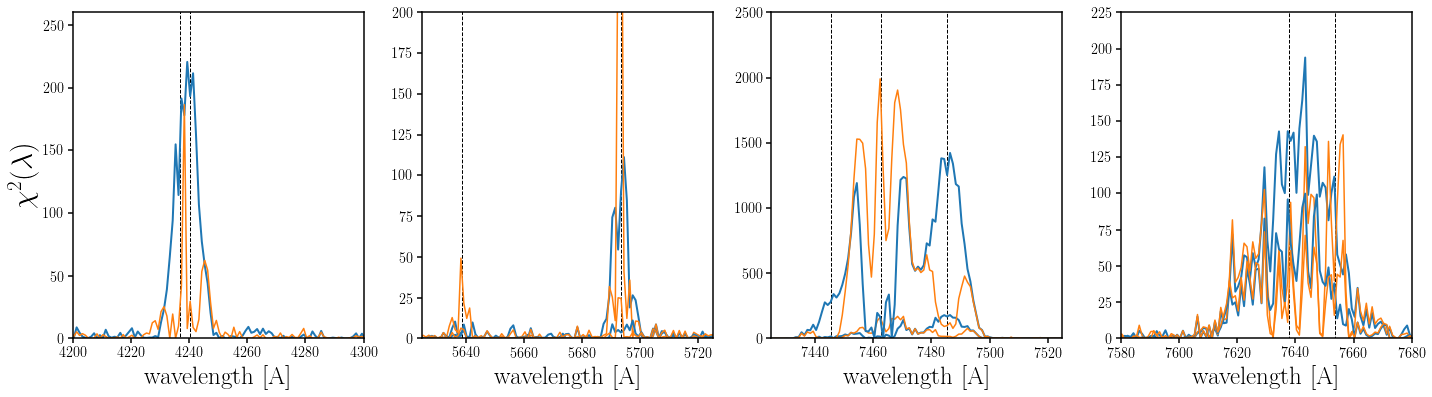

In [33]:
igal = np.arange(len(i_dark))[zfail_dark_ha][3]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']
#emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
#emline_lambda = [3726., 3729., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]
emline_xval = [3715., 3732., 4861., 4959., 5007., 6300., 6364., 6548., 6570., 6583., 6717., 6731.]

xlims = [[4200., 4300.], [5625., 5725.], [7425., 7525.], [7580, 7680]]
ylims0 = [[0., 5e1], [0., 2e1], [0., 2e2], [0., 3.5e1]]
ylims1 = [[0., 2.6e2], [0., 2e2], [0., 2.5e3], [0., 2.25e2]]

fig = plt.figure(figsize=(len(xlims)*6,6)) 
for i_x, xlim in enumerate(xlims): 
    _ax2 = fig.add_subplot(1,len(xlims),i_x+1)
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for i_s, spec in enumerate(specs_to_read):
        emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
        for i_l, zlambda in enumerate(emline_zlambda):
            if zlambda < xlim[0] or zlambda > xlim[1]: continue
            # mark the redshifted wavelength of the emission line
            _ax2.vlines(zlambda, -100., 1e5, color='k', linestyle='--', linewidth=0.5)
            _ax2.text((1.+redshift[i_dark][igal])*emline_xval[i_l], 1.075*ylims0[i_x][1], 
                      emline_labels[i_l],ha='left', va='top', fontsize=20)    
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, flux, c='k', lw=1, label='Synthetic Spectra')#alpha=0.5)
        #_ax2.plot(spec.wave, medfilt(flux, 1), c='C1', lw=2)#alpha=0.5)

        # correct answer
        mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
        model = spec.R.dot(mx)
        isbad = (spec.ivar == 0)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), c='C1', lw=1.5, label='Template w/ Correct $z$')

        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), 'C0-', lw=1.5, label='Best-fit Template')
        if (i_s == 0) and (i_x == len(xlims)-1): _ax2.legend(loc='upper right', frameon=True, prop={'size': 20})
    #- Label object type and redshift
    if i_x == 0: 
        _ax2.text(xlim[0]+0.1*(xlim[1]-xlim[0]), ylims0[i_x][0]+0.83*(ylims0[i_x][1]-ylims0[i_x][0]), 
                  r"$z_\mathrm{redrock}="+str(round(zz['z'],3))+'$\n $z_\mathrm{input}='+str(redshift[i_dark][igal])+'$', 
                 fontsize=22.5)
    _ax2.set_ylim(ylims0[i_x])
    _ax2.set_xlim(xlim)   
    if i_x == 0: _ax2.set_ylabel('flux', fontsize=25)

fig = plt.figure(figsize=(len(xlims)*6,6)) 
for i_x, xlim in enumerate(xlims): 
    sub = fig.add_subplot(1,len(xlims),i_x+1)

    emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
    for i_l, zlambda in enumerate(emline_zlambda):
        if zlambda < xlim[0] or zlambda > xlim[1]: continue
        # mark the redshifted wavelength of the emission line
        sub.vlines(zlambda, -100., 1e5, color='k', linestyle='--', linewidth=1)
        #sub.text((1.+redshift[i_dark][igal])*emline_xval[i_l], 200., emline_labels[i_l], ha='left', va='top', fontsize=12)

    specs_to_read = target.spectra
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        ivar = spec.ivar.copy() 
        isbad = (spec.ivar == 0)
        chi2 = (flux - model)**2 * ivar
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, c='C0', lw=2) 

        mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
        model = spec.R.dot(mx)
        isbad = (spec.ivar == 0)
        model[isbad] = np.NaN
        chi2 = (flux - model)**2 * ivar
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2, c='C1', lw=1.5) 
    sub.set_ylim(ylims1[i_x])
    #sub.set_yscale('log')
    sub.set_xlim(xlim)   
    if i_x == 0: sub.set_ylabel('$\chi^2(\lambda)$', fontsize=30)
    sub.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
plt.show()

i = 294 with z = 0.137084


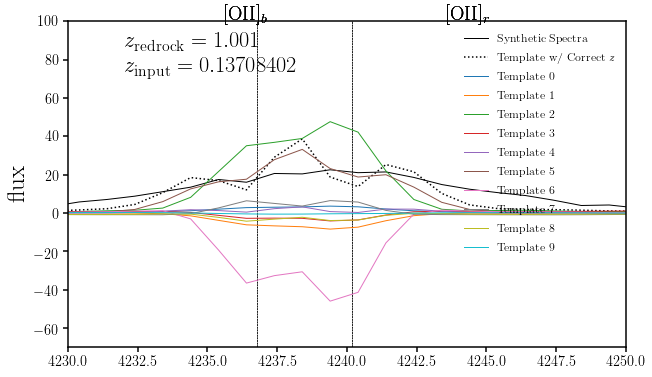

In [34]:
igal = np.arange(len(i_dark))[zfail_dark_ha][3]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']
#emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
#emline_lambda = [3726., 3729., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]
emline_xval = [3725., 3732., 4861., 4959., 5007., 6300., 6364., 6548., 6570., 6583., 6717., 6731.]

xlims = [[4230., 4250.]]
ylims0 = [[-7e1, 1e2]]
ylims1 = [[0., 2.6e2]]

fig = plt.figure(figsize=(10,6)) 
for i_x, xlim in enumerate(xlims): 
    _ax2 = fig.add_subplot(1,len(xlims),i_x+1)
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for i_s, spec in enumerate(specs_to_read):
        emline_zlambda = (1.+redshift[i_dark][igal]) * np.array(emline_lambda)
        for i_l, zlambda in enumerate(emline_zlambda):
            if zlambda < xlim[0] or zlambda > xlim[1]: continue
            # mark the redshifted wavelength of the emission line
            _ax2.vlines(zlambda, -100., 1e5, color='k', linestyle='--', linewidth=0.5)
            _ax2.text((1.+redshift[i_dark][igal])*emline_xval[i_l], 1.075*ylims0[i_x][1], 
                      emline_labels[i_l],ha='left', va='top', fontsize=20)    
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, flux, c='k', lw=1, label='Synthetic Spectra')#alpha=0.5)
        #_ax2.plot(spec.wave, medfilt(flux, 1), c='C1', lw=2)#alpha=0.5)

        # correct answer
        mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, zz_other['z']) * (1+zz_other['z'])
        model = spec.R.dot(mx)
        isbad = (spec.ivar == 0)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), c='k', lw=1.5, ls=':', label='Template w/ Correct $z$')
        for ii in range(tp.nbasis): 
            #print('%i th pca template coeff = %f' % (ii, zz_other['coeff'][ii]))
            coeff_ii = np.zeros(tp.nbasis) 
            coeff_ii[ii] = zz_other['coeff'][ii]
            mx = spec.R.dot(tp.eval(coeff_ii, spec.wave, zz_other['z']) * (1+zz_other['z']))
            _ax2.plot(spec.wave, mx, lw=1, c='C'+str(ii), label=('Template %i' % ii))
            
        if (i_s == 0) and (i_x == len(xlims)-1): _ax2.legend(loc='upper right', prop={'size': 12})
    #- Label object type and redshift
    if i_x == 0: 
        _ax2.text(xlim[0]+0.1*(xlim[1]-xlim[0]), ylims0[i_x][0]+0.83*(ylims0[i_x][1]-ylims0[i_x][0]), 
                  r"$z_\mathrm{redrock}="+str(round(zz['z'],3))+'$\n $z_\mathrm{input}='+str(redshift[i_dark][igal])+'$', 
                 fontsize=22.5)
    _ax2.set_ylim(ylims0[i_x])
    _ax2.set_xlim(xlim)   
    if i_x == 0: _ax2.set_ylabel('flux', fontsize=25)

i = 294 with z = 0.137084


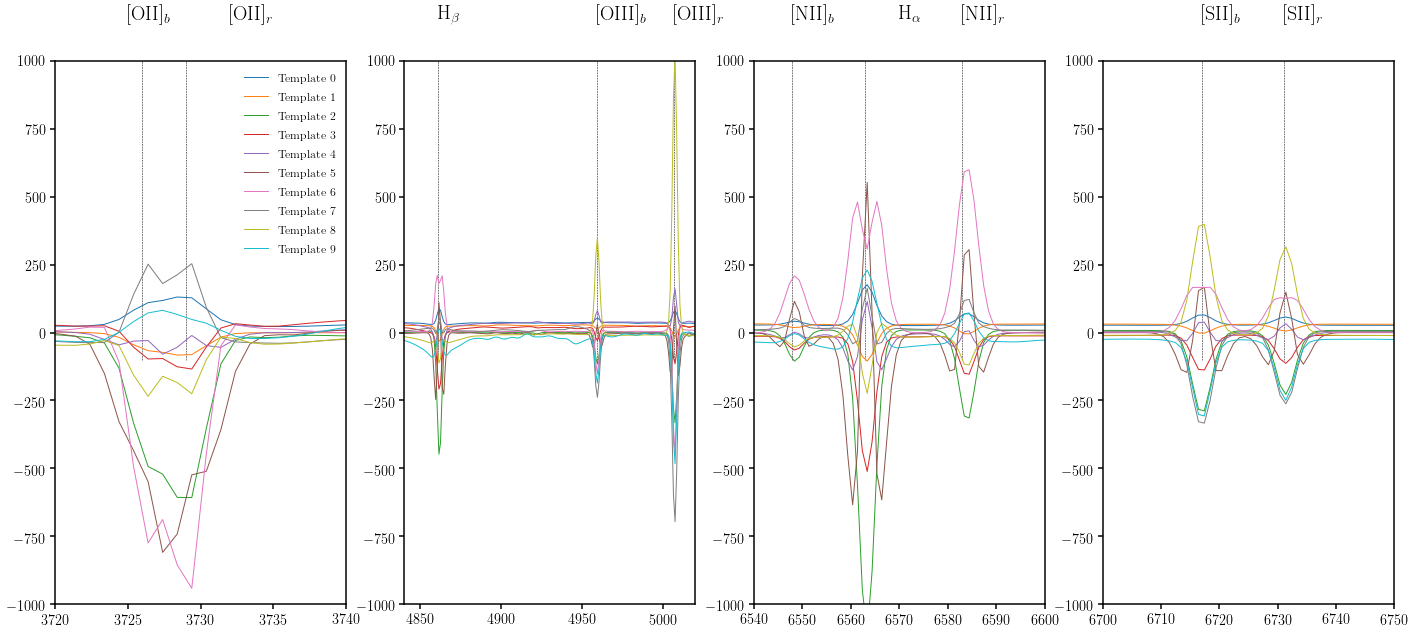

In [35]:
igal = np.arange(len(i_dark))[zfail_dark_ha][3]
print('i = %i with z = %f' % (igal, redshift[i_dark][igal]))

target = target_dark[igal]
zscan = zscan_dark
zfit = zfit_dark
zfit_i = zfit[zfit['targetid'] == target.id]
zz = zfit_i[zfit_i['znum'] == 0][0]
zz_other = zfit_i[zfit_i['znum'] == 1][0]
coeff = zz['coeff']

ymin = ymax = 0.0
#emline_keys = ['oiib', 'oiir', 'hb',  'oiiib', 'oiiir', 'oib', 'oir', 'niib', 'ha', 'niir', 'siib', 'siir']
emline_lambda = [3726., 3729., 4861., 4959., 5007., 6300., 6364., 6548., 6563., 6583., 6717., 6731.]
emline_xval = [3725., 3732., 4861., 4959., 5007., 6300., 6364., 6548., 6570., 6583., 6717., 6731.]

xlims = [[3720., 3740.], [4840., 5020.], [6540, 6600], [6700, 6750]]
ylims0 = [[-1e3, 1e3], [-1e3, 1e3], [-1e3, 1e3], [-1e3, 1e3]]

fig = plt.figure(figsize=(len(xlims)*6,10)) 
for i_x, xlim in enumerate(xlims): 
    _ax2 = fig.add_subplot(1,len(xlims),i_x+1)
    specs_to_read = target.spectra
    
    for i_l, zlambda in enumerate(emline_lambda):
        if zlambda < xlim[0] or zlambda > xlim[1]: continue
        # mark the redshifted wavelength of the emission line
        _ax2.vlines(zlambda, -100., 1e5, color='k', linestyle='--', linewidth=0.5)
        _ax2.text(emline_xval[i_l], 1.2*ylims0[i_x][1], 
                      emline_labels[i_l],ha='left', va='top', fontsize=20)    
    for i_s, spec in enumerate(specs_to_read):
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        flux[isbad] = np.NaN
        #_ax2.plot(spec.wave, flux, c='k', lw=1, label='Synthetic Spectra')#alpha=0.5)
        #_ax2.plot(spec.wave, medfilt(flux, 1), c='C1', lw=2)#alpha=0.5)

        # correct answer
        #mx = tp.eval(zz_other['coeff'][0:tp.nbasis], spec.wave, 0.)
        #model = spec.R.dot(mx)
        #isbad = (spec.ivar == 0)
        #model[isbad] = np.NaN
        #_ax2.plot(spec.wave, medfilt(model, 1), c='k', lw=1.5, ls=':', label='Template w/ Correct $z$')
        for ii in range(tp.nbasis): 
            coeff_ii = np.zeros(tp.nbasis)
            coeff_ii[ii] = 1.e4
            mx = spec.R.dot(tp.eval(coeff_ii, spec.wave, -0.0002)*0.9998)
            _ax2.plot(spec.wave, mx, lw=1, c='C'+str(ii), label=('Template %i' % ii))

        if (i_s == 0) and (i_x == 0): _ax2.legend(loc='upper right', prop={'size': 12})
    _ax2.set_ylim(ylims0[i_x])
    _ax2.set_xlim(xlim)   
    if i_s == 0: _ax2.set_ylabel('flux', fontsize=25)